# <center>Household Power Consumption Prediction<center/>

### Description 
This notebook implements a an sequential model from Household Power Consumption Prediction. Model input are measurements of electric power consumption. Data was gathered from one household with a one-minute sampling rate over a period of almost 4 years.

#### Data Set Information:

The dataset contains 2075259 samples/measurements gathered between December 2006 and November 2010 (47 months).<br>
**NOTE**: 
> (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

> The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

**Data Attributes Information:** 

1. date: Date in format dd/mm/yyyy

2. time: time in format hh:mm:ss

3. global_active_power: household global minute-averaged active power (in kilowatt)

4. global_reactive_power: household global minute-averaged reactive power (in kilowatt)

5. voltage: minute-averaged voltage (in volt)

6. global_intensity: household global minute-averaged current intensity (in ampere)

7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner. <br>

#### Task : 
> Predict the power consumption together with upper and lower interval

### Import necessary libraries 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm

import lightgbm as lgb
from catboost import CatBoostRegressor

### Read data

In [2]:
data_path = "../Dataset/household_power_consumption_data.zip"
df = pd.read_csv(data_path, sep=';',parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'],index_col='dt')
df.drop(["Global_active_power","Global_reactive_power","Voltage","Global_intensity"],axis=1,inplace=True)

### Preprocess Data
Fill NaN values by average, extract features from timestamps & group the data

In [3]:
#fill nan values with column average
for j in range(0,3):
    df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

df["consumption"] = df.iloc[:,:].sum(axis=1)
df.head()

,Sub_metering_1,Sub_metering_2,Sub_metering_3,consumption
dt,,,,
2006-12-16 17:24:00,0.0,1.0,17.0,18.0
2006-12-16 17:25:00,0.0,1.0,16.0,17.0
2006-12-16 17:26:00,0.0,2.0,17.0,19.0
2006-12-16 17:27:00,0.0,1.0,17.0,18.0
2006-12-16 17:28:00,0.0,1.0,17.0,18.0


In [5]:
#Extract features from timestamp 
def features_from_timestamp(t):
    h = t.hour
    year = t.year
    idx = np.searchsorted(list(range(3,25,3)),h,side='right')
    interval = np.arange(3,25,3)[idx]
    if  interval == 24 : interval = 0
    month = t.month
    season = (month in [11,12,1,2,3]) * 1 # 0: summer, 1:  winter
    return [t.day, t.dayofweek,h,interval,month,season]


col = ['day', 'dayofweek', 'hour', 'interval', 'month', 'season']

In [6]:
grouped = df["consumption"].groupby(pd.Grouper(freq='1h', base=0, label='right')).sum()
data = pd.DataFrame(grouped/60)

#Get intervals

# Generate aditional features from timestamp then append to exixting data
additional_featues = pd.DataFrame(data = [features_from_timestamp(i) for i in tqdm(data.index) ],columns=col).set_index(data.index)
data = data.merge(additional_featues,on="dt")
data.sort_index(inplace=True) #make sure data is sorted by date

for col in list(data.columns)[1:]:
    data[col] = data[col].astype("category")
cate_features_name = ['day', 'dayofweek', 'hour', 'interval', 'month', 'season']

data.head()

100%|██████████| 34589/34589 [00:00<00:00, 38329.67it/s]


,consumption,day,dayofweek,hour,interval,month,season
dt,,,,,,,
2006-12-16 18:00:00,10.433333,16,5,18,21,12,1
2006-12-16 19:00:00,23.583333,16,5,19,21,12,1
2006-12-16 20:00:00,18.116667,16,5,20,21,12,1
2006-12-16 21:00:00,16.783333,16,5,21,0,12,1
2006-12-16 22:00:00,17.633333,16,5,22,0,12,1


In [15]:
from sklearn.metrics import mean_absolute_error
def plot_moving_averages(df,window,plot_intervals=False, scale=1.96):

    assert(isinstance(df, pd.DataFrame) or isinstance(df, pd.Series) == True ), "Input data should be a pandas Dataframe or Series"
    # if not isinstance(df, pd.DataFrame) : print("Input data should be a pandas Dataframe or Series")
    rolling_mean = df.rolling(window).mean()
#     rolling_mean = df
    

    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean,label='Rolling mean trend')
    #Plot confidence intervals for smoothed values
    if plot_intervals :
        mae = mean_absolute_error(df[window:], rolling_mean[window:])
        deviation = np.std(df[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(df[window:], label='Actual values')
    plt.legend(loc='best')
    plt.show()

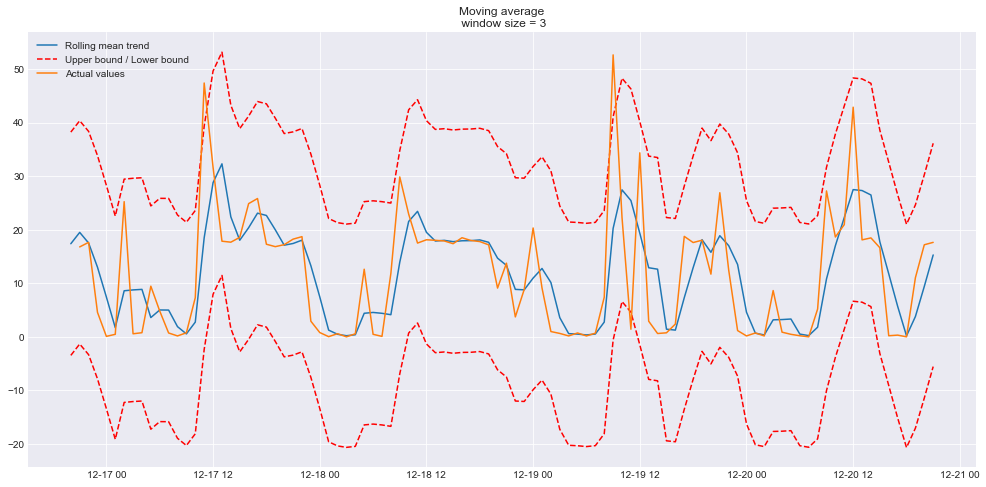

In [25]:
plot_moving_averages(data.consumption[:100],window=3
                     ,plot_intervals=True)

### Create dataset with upper bound and lower bound
For each record look back one month and calculate the standard deviation, quantile (5% and 95%) and the mean energy consumption. Check if each record is between the upper bound and lower bound (5 and 95 percent quantile in this case)

In [ ]:
data2 = pd.DataFrame(grouped/60)
def get_intervals(t):
    global data2
    lookback = t - pd.Timedelta('730hr')
    day_name = t.day_name()
    mask = ((data2.index >= lookback) & (data2.index <= t))

    if np.sum(mask) < 144:
        return [np.nan, np.nan,np.nan,np.nan]

    d = data[mask].groupby(data[mask].index.weekday_name)
#     temp = d.get_group(day_name).values
    temp = d.get_group(day_name)
    temp = temp.groupby(temp.index.hour)
    k = t.hour if len(temp.groups.keys()) == 24 else t.hour - 1
    if k == -1 :
        k = 23
    
    temp = temp.get_group(k).values

    p1 = np.quantile(temp,0.05)
    p2 = np.quantile(temp,0.95)
    
    return [temp.std() ,temp.mean(), p1, p2]
    

In [ ]:
add_col = ["std","mean","p1","p2"]
addi = pd.DataFrame(data = [get_intervals(i) for i in tqdm(data2.index)],columns=add_col).set_index(data2.index)
data2 = data2.merge(addi,on="dt")
data2.dropna(inplace=True)
data2['in_bounds'] = data2["consumption"].between(left=data2['p1'], right=data2['p2'])

In [ ]:
data2.head()

In [ ]:
data2.in_bounds.value_counts(normalize=True)

### Split data to train and test
Take one year as test sample (2010) and 3 years as trainning set (2006 - 2009)

In [26]:
#Split data to train and test
xtrain = data.loc["2006":"2010"]
ytrain = xtrain.pop("consumption")

xtest = data.loc["2010":]
ytest = xtest.pop("consumption")

### Define models & Train models
Define and set modes training paramaters

#### Use sklearn Gradient Boosting Regressor

In [27]:
LOWER_ALPHA = 0.10
UPPER_ALPHA = 0.90

N_ESTIMATORS = 700
MAX_DEPTH = 5

# Each model has to be separate
lower_model = GradientBoostingRegressor(loss="quantile", alpha=LOWER_ALPHA, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)
# The mid model will use the default loss
mid_model = GradientBoostingRegressor(loss="ls", n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)
upper_model = GradientBoostingRegressor(loss="quantile", alpha=UPPER_ALPHA, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)


#Train Models
_ = lower_model.fit(xtrain, ytrain)
_ = mid_model.fit(xtrain, ytrain)
_ = upper_model.fit(xtrain, ytrain)

In [28]:
mse = mean_squared_error(mid_model.predict(xtest),ytest)
print("Gradient Boosting Regressor MSE : {}".format(mse))

Gradient Boosting Regressor MSE : 49.41127020191252


#### Use LightGBM

In [29]:
# params = {"task":"train","max_depth": -1, "objective": "quantile","learning_rate" : 0.1,
#           "alpha":0.5 ,"num_leaves": 900,'metric': {'l2', 'auc'},  "n_estimators": 700,
#          "n_jobs" : -1}

# d_train = lgb.Dataset(xtrain, label=ytrain, categorical_feature = cate_features_name)
# model2 = lgb.train(params, d_train)

lower_model_lgbm = lgb.LGBMRegressor(objective="quantile",alpha=0.05,n_estimators=700,max_depth=15,n_jobs=-1, learning_rate= 0.1,
                                   num_leaves= 900)
mid_model_lgbm = lgb.LGBMRegressor(objective="quantile",alpha=0.5,n_estimators=700,max_depth=15,n_jobs=-1, learning_rate= 0.1,
                                   num_leaves= 900)
upper_model_lgbm = lgb.LGBMRegressor(objective="quantile",alpha=0.95,n_estimators=700,max_depth=15,n_jobs=-1, learning_rate= 0.1,
                                     num_leaves= 900)
#Train Models
lower_model_lgbm.fit(xtrain, ytrain,verbose = 0,categorical_feature=cate_features_name,eval_metric = ['l2', 'auc'])
mid_model_lgbm.fit(xtrain, ytrain,verbose = 0,categorical_feature=cate_features_name,eval_metric = ['l2', 'auc'])
upper_model_lgbm.fit(xtrain, ytrain,verbose = 0,categorical_feature=cate_features_name,eval_metric = ['l2', 'auc'])


/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'interval', 'month', 'season']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'interval', 'month', 'season']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['day', 'dayofweek', 'hour', 'interval', 'month', 'season']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMRegressor(alpha=0.95, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
              max_depth=15, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=700, n_jobs=-1, num_leaves=900,
              objective='quantile', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [30]:
mse = mean_squared_error(mid_model_lgbm.predict(xtest),ytest)
print("LightGBM MSE : {}".format(mse))

LightGBM MSE : 39.034816811204465


### Predictions

In [31]:
predictions = pd.DataFrame(ytest)
predictions['lower'] = lower_model_lgbm.predict(xtest)
predictions['mid'] = mid_model_lgbm.predict(xtest)
predictions['upper'] = upper_model_lgbm.predict(xtest)

assert (predictions['upper'] > predictions['lower']).all()

predictions.tail()

,consumption,lower,mid,upper
dt,,,,
2010-11-26 18:00:00,12.866667,0.254194,10.046295,13.817498
2010-11-26 19:00:00,0.000000,-0.011783,0.279862,13.489570
2010-11-26 20:00:00,0.066667,0.066107,0.058905,17.734424
2010-11-26 21:00:00,1.066667,0.890995,9.476422,28.017457
2010-11-26 22:00:00,0.000000,0.050921,6.159489,16.741910


In [32]:
#Clip negative values to zero
predictions.loc[predictions['lower'] < 0.0, "lower"] = 0.0
predictions.loc[predictions['mid'] < 0.0, "mid"] = 0.0

### Calculate model Error

In [33]:
def calculate_error(predictions):
    predictions['absolute_error_lower'] = (predictions['lower'] - predictions["consumption"]).abs()
    predictions['absolute_error_upper'] = (predictions['upper'] - predictions["consumption"]).abs()
    
    predictions['absolute_error_interval'] = (predictions['absolute_error_lower'] + predictions['absolute_error_upper']) / 2
    predictions['absolute_error_mid'] = (predictions['mid'] - predictions["consumption"]).abs()
    
    predictions['in_bounds'] = predictions["consumption"].between(left=predictions['lower'], right=predictions['upper'])
    

In [34]:
calculate_error(predictions)
metrics = predictions[['absolute_error_lower', 'absolute_error_upper', 'absolute_error_interval', 'absolute_error_mid', 'in_bounds']].copy()
metrics.describe()

,absolute_error_lower,absolute_error_upper,absolute_error_interval,absolute_error_mid
count,7919.000000,7919.000000,7919.000000,7919.000000
mean,8.169306,9.440444,8.804875,3.424344
std,9.207879,8.070582,4.538421,5.225170
min,0.000000,0.000002,0.082108,0.000000
25%,0.816667,2.701518,5.216139,0.078012
50%,3.899372,7.827986,8.784095,0.893171
75%,15.467443,14.586488,11.531587,5.013725
max,69.846124,51.011209,34.936594,53.909106


In [35]:
predictions.in_bounds.value_counts(normalize=True)

True     0.930294
False    0.069706
Name: in_bounds, dtype: float64

### Plot model predictions

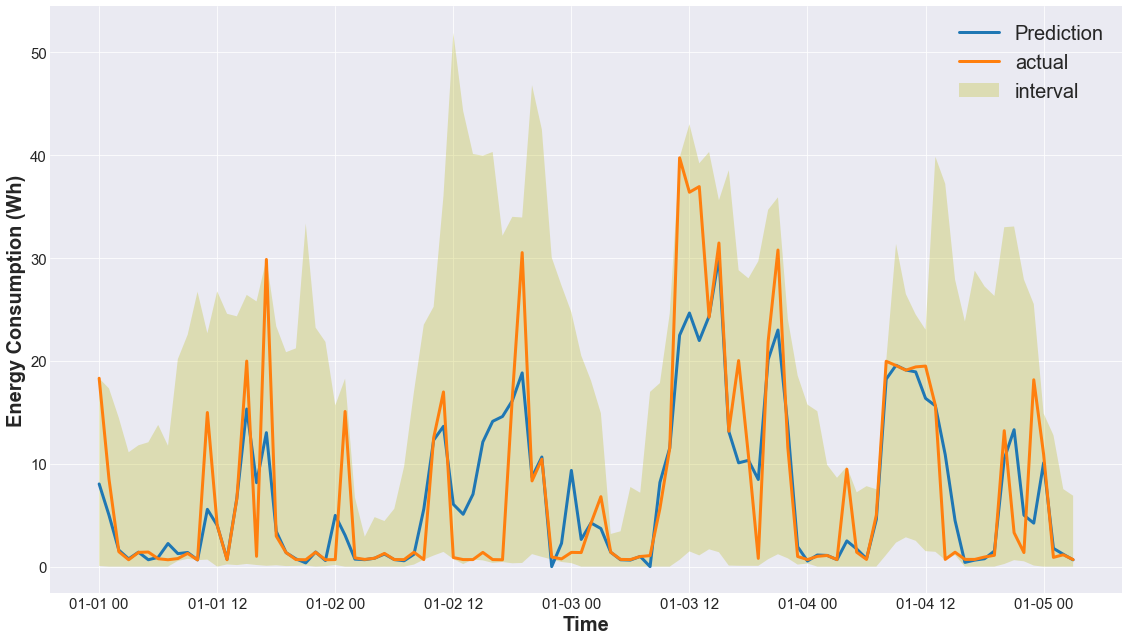

In [36]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
n = 100
fig = plt.figure(figsize=(19.20,10.80))
# plt.plot(predictions.index[100:150], predictions.lower[100:150],label="Lower",linewidth=3)
plt.plot(predictions.index[:n], predictions.mid[:n],label="Prediction",linewidth=3)
# plt.plot(predictions.index[100:150], predictions.upper[100:150], label="Upper",linewidth=3)
plt.fill_between(predictions.index[:n], predictions.lower[:n], predictions.upper[:n],
                 alpha=0.3, facecolor=colors[8],label='interval')
plt.plot(predictions.index[:n], predictions.consumption[:n],label="actual",linewidth=3)
plt.legend(loc=0,prop={'size': 20})
plt.ylabel("Energy Consumption (Wh)",fontsize=20.0,fontweight="bold")
plt.xlabel("Time",fontsize=20.0,fontweight="bold")
plt.tick_params(labelsize=15)
plt.show()

### Exploratory Data Analysis (optional)

In [ ]:
# import pandas_profiling
# profile = pandas_profiling.ProfileReport(df)
# profile.to_file("report.html")
# profile

### <center> Predictions of intervals using Deep Quantile Regression (Deep Neural network) <center/>

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras.backend as K

In [ ]:
#scale data
scaler = StandardScaler()
std_xtrain = scaler.fit_transform(xtrain.values)
std_xtest = scaler.transform(xtest.values)

In [ ]:
def quantile_loss(q,y,f):
    # q: Quantile to be evaluated, e.g., 0.5 for median.
    # y: True value.
    # f: Fitted (predicted) value.
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)


In [ ]:
def BaseModel():
    model = Sequential()
    model.add(Dense(units=10, input_dim=6,activation='relu'))
    model.add(Dense(units=10, input_dim=1,activation='relu'))
    model.add(Dense(1))
    
    return model

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

model_lower = BaseModel()
model_lower.compile(loss=lambda y,f: quantile_loss(0.1,y,f), optimizer='adadelta')
model_lower.fit(std_xtrain, ytrain, epochs=200, batch_size=32, verbose=0,validation_split=0.2, callbacks=[early_stop])

model_middle = BaseModel()
model_middle.compile(loss=lambda y,f: quantile_loss(0.5,y,f), optimizer='adadelta')
model_middle.fit(std_xtrain, ytrain, epochs=200, batch_size=32, verbose=0,validation_split=0.2, callbacks=[early_stop])

model_upper = BaseModel()
model_upper.compile(loss=lambda y,f: quantile_loss(0.9,y,f), optimizer='adadelta')
model_upper.fit(std_xtrain, ytrain, epochs=200, batch_size=32, verbose=0,validation_split=0.2, callbacks=[early_stop])
